In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import random
from random import randint
import time
import os
import numpy as np
from collections import namedtuple
import cv2
from pathlib import Path
import argparse
import os
import csv
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow import keras

In [3]:
#folder_path_1 = "./data/이상(방화)"
folder_path_2 = "./data/이상(유기)"
#folder_path_3 = "./data/이상(전도)"
#folder_path_4 = "./data/이상(절도)"
folder_path_5 = "./data/이상(파손)"
folder_path_6 = "./data/이상(폭행)"
#folder_path_7 = "./data/이상(흡연)"
#folder_path_7 = "./data/이상(교통약자)"
#folder_path_8 = "./data/구매(구매)"
folder_path_9 = "./data/구매(반품)"
folder_path_10 = "./data/구매(비교)"
folder_path_11 = "./data/구매(선택)"

In [4]:
def concat(path):
    file_lst = os.listdir(path)
    df_list = []
    for file in file_lst:
        file_name = os.path.join(path, file)
        df = pd.read_csv(file_name)
        df = df[df.NUMOFBODIES != 0].reset_index(drop=True)
###
        if len(df) < 610:
            pad_length = 610 - len(df)
            pad_df = pd.DataFrame(0, index=range(len(df), 610), columns=df.columns)
            df = pd.concat([df, pad_df])
        df['index_num'] = df.index
###
        df_list.append(df)
    #concat_df = pd.concat(df_list, ignore_index=True)
    return df_list

In [5]:
#fire_mer = concat(folder_path_1)
yugi_mer = concat(folder_path_2)
#jeon_mer = concat(folder_path_3)
#theft_mer = concat(folder_path_4)
damage_mer = concat(folder_path_5)
violence_mer = concat(folder_path_6)
#smoke_mer = concat(folder_path_7)
#buy_mer = concat(folder_path_8)
refund_mer = concat(folder_path_9)
compar_mer = concat(folder_path_10)
select_mer = concat(folder_path_11)
#test_mer = pd.concat(test_mer, ignore_index=True)

In [6]:
#buy_mer = pd.concat(buy_mer, ignore_index=True)
refund_mer = pd.concat(refund_mer, ignore_index=True)
compar_mer = pd.concat(compar_mer, ignore_index=True)
select_mer = pd.concat(select_mer, ignore_index=True)
#fire_mer = pd.concat(fire_mer, ignore_index=True)
yugi_mer = pd.concat(yugi_mer, ignore_index=True)
#jeon_mer = pd.concat(jeon_mer, ignore_index=True)
#theft_mer = pd.concat(theft_mer, ignore_index=True)
damage_mer = pd.concat(damage_mer, ignore_index=True)
violence_mer = pd.concat(violence_mer, ignore_index=True)
#smoke_mer = pd.concat(smoke_mer, ignore_index=True)

In [7]:
#buy_mer['LABEL'] = 0
refund_mer['LABEL'] = 0
compar_mer['LABEL'] = 1
select_mer['LABEL'] = 2
#fire_mer['LABEL'] = 4
yugi_mer['LABEL'] = 3
#jeon_mer['LABEL'] = 6
#theft_mer['LABEL'] = 7
damage_mer['LABEL'] = 4
violence_mer['LABEL'] = 5
#smoke_mer['LABEL'] = 10

In [8]:
mer_lst = [#fire_mer,
            yugi_mer,
            #jeon_mer,
            #theft_mer,
            damage_mer,
            violence_mer,
            #smoke_mer,
            #buy_mer,
            refund_mer,
            compar_mer,
            select_mer]
full_data = pd.concat(mer_lst, ignore_index=True)
full_data.shape

(1536590, 40)

In [9]:
# 데이터와 레이블을 추출합니다
label_data = full_data['LABEL']
data_without_label = full_data.drop(['ID', 'TIMESTAMP', 'FRAME_NUM', 'LABEL'], axis=1)


In [10]:
data_without_label.head(10)

,NUMOFBODIES,NOSE_X,NOSE_Y,LEFT_EYE_X,LEFT_EYE_Y,RIGHT_EYE_X,RIGHT_EYE_Y,LEFT_EAR_X,LEFT_EAR_Y,RIGHT_EAR_X,...,RIGHT_HIP_Y,LEFT_KNEE_X,LEFT_KNEE_Y,RIGHT_KNEE_X,RIGHT_KNEE_Y,LEFT_ANKLE_X,LEFT_ANKLE_Y,RIGHT_ANKLE_X,RIGHT_ANKLE_Y,index_num
0,1,926,151,937,141,926,140,954,144,926,...,297,946,375,893,363,929,454,914,442,0
1,1,908,143,916,135,905,135,931,141,902,...,313,927,414,885,401,933,484,890,474,1
2,1,884,164,894,153,880,153,906,154,880,...,319,912,404,854,402,906,487,846,489,2
3,1,853,162,864,152,844,153,873,156,834,...,330,894,422,840,421,895,495,853,501,3
4,1,821,179,829,168,823,168,849,170,840,...,360,874,469,837,465,887,558,852,546,4
5,1,820,185,830,173,820,171,854,178,834,...,370,870,490,828,474,881,565,846,551,5
6,2,884,188,879,177,882,178,876,190,883,...,306,925,306,940,305,933,244,931,242,6
7,2,803,194,809,182,813,182,828,188,837,...,391,821,514,859,498,804,617,831,606,7
8,1,782,204,795,191,778,190,821,192,786,...,415,862,539,809,547,856,617,809,644,8
9,1,759,215,773,200,757,198,805,204,771,...,444,859,578,786,571,872,663,809,659,9


In [11]:
sequence_start_indices = full_data.index[full_data['index_num'] == 0].tolist()
sequence_lengths = [sequence_start_indices[i] - sequence_start_indices[i-1] for i in range(1, len(sequence_start_indices))]
sequence_lengths.insert(0, sequence_start_indices[0])

# Min sequence length
min_sequence_length = min(sequence_lengths)

In [12]:
min_sequence_length = 610

In [13]:
X_sequences = []
y_sequences = []

# Iterating over the start indices to create sequences
for i in range(len(sequence_start_indices) - 1):
    start_index = sequence_start_indices[i]
    end_index = sequence_start_indices[i + 1]

    # Ensure the sequence has the expected length before appending
    if end_index - start_index == min_sequence_length:
        X_sequence = data_without_label.iloc[start_index:end_index].values
        y_sequence = label_data.iloc[start_index:end_index].values
        X_sequences.append(X_sequence)
        y_sequences.append(y_sequence[-1])  # Taking the label of the last frame for the sequence

# Converting lists to numpy arrays
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

X_sequences.shape, y_sequences.shape


((2518, 610, 36), (2518,))

In [14]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X_sequences, y_sequences, test_size=0.3, random_state=48)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=48)

In [15]:
print(X_train.shape, y_train.shape)

(1762, 610, 36) (1762,)


In [16]:
print(X_temp.shape, y_temp.shape)

(756, 610, 36) (756,)


In [17]:
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_val = X_val.astype(np.float32)
y_val = y_val.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 모델 정의
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 훈련 데이터에 대한 샘플 가중치 마스크 생성
# 패딩이 아닌 값은 1, 패딩된 값은 0
sample_weight_train = np.where(X_train != 0, 1, 0)
sample_weight_train = sample_weight_train.max(axis=-1)

# 각 시퀀스에 대한 평균 샘플 가중치 계산
sample_weight_train_avg = sample_weight_train.mean(axis=1)

In [20]:
model_file_path = "./model/sum_all_36.h5"
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_file_path)
# - 자동 훈련 멈추기 함수 사용 : 추가 훈련 epoch 2회, 가중치 업데이트
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                        restore_best_weights=True)


# 4. Model Training
# 모델 훈련
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000,
                    batch_size=128, sample_weight=sample_weight_train_avg,
                    callbacks=[checkpoint_cb, early_stopping_cb])

# 5. Model Evaluation
# 모델 평가
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")


Epoch 1/1000
14/14 [==============================] - 39s 3s/step - loss: 1.0622 - accuracy: 0.4989 - val_loss: 1.1050 - val_accuracy: 0.4820
Epoch 2/1000
14/14 [==============================] - 51s 4s/step - loss: 1.0605 - accuracy: 0.5204 - val_loss: 1.1041 - val_accuracy: 0.5198
Epoch 3/1000
14/14 [==============================] - 49s 3s/step - loss: 1.0750 - accuracy: 0.4960 - val_loss: 1.0992 - val_accuracy: 0.5047
Epoch 4/1000
14/14 [==============================] - 49s 4s/step - loss: 1.0650 - accuracy: 0.5136 - val_loss: 1.1159 - val_accuracy: 0.4707
Epoch 5/1000
14/14 [==============================] - 44s 3s/step - loss: 1.0638 - accuracy: 0.5289 - val_loss: 1.1687 - val_accuracy: 0.4442
Epoch 6/1000
14/14 [==============================] - 43s 3s/step - loss: 1.0620 - accuracy: 0.5148 - val_loss: 1.0894 - val_accuracy: 0.5009
Epoch 7/1000
14/14 [==============================] - 51s 4s/step - loss: 1.0405 - accuracy: 0.5329 - val_loss: 1.0724 - val_accuracy: 0.5274
Epoch 

In [21]:
from keras.models import load_model
model1 = load_model('./model/sum_all_32.h5')

In [22]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 610, 128)          84480     
                                                                 
 lstm_1 (LSTM)               (None, 610, 64)           49408     
                                                                 
 dropout (Dropout)           (None, 610, 64)           0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 6)                 198       
                                                                 
Total params: 146,502
Trainable params: 146,502
Non-trai

In [23]:
X_sequences, y_sequences
X_val = X_sequences.astype(np.float32)
y_val = y_sequences.astype(np.float32)

In [24]:
### 불러온 모델로 데이터 정확도 확인하기
# - 예측
test_preds = model1.predict(X_val)
test_preds.shape

(2518, 6)

In [25]:
np.unique(y_val, return_counts=True)

(array([0., 1., 2., 3., 4., 5.], dtype=float32),
 array([148, 152, 292, 642, 642, 642], dtype=int64))

In [26]:
cate = [ '구매(반품)', '구매(비교)', '구매(선택)','이상(유기)','이상(파손)','이상(폭행)',]

In [27]:
# 유니크한 종속변수들을 얻습니다.
unique_targets = np.unique(y_val)

# 테스트 데이터에 대한 예측을 한 번만 수행
test_preds = model1.predict(X_val)
test_pred_idx = [np.argmax(pred) for pred in test_preds]

In [28]:
np.unique(test_pred_idx)

array([1, 2, 3, 4, 5], dtype=int64)

In [29]:
test_pred_idx = np.array(test_pred_idx)

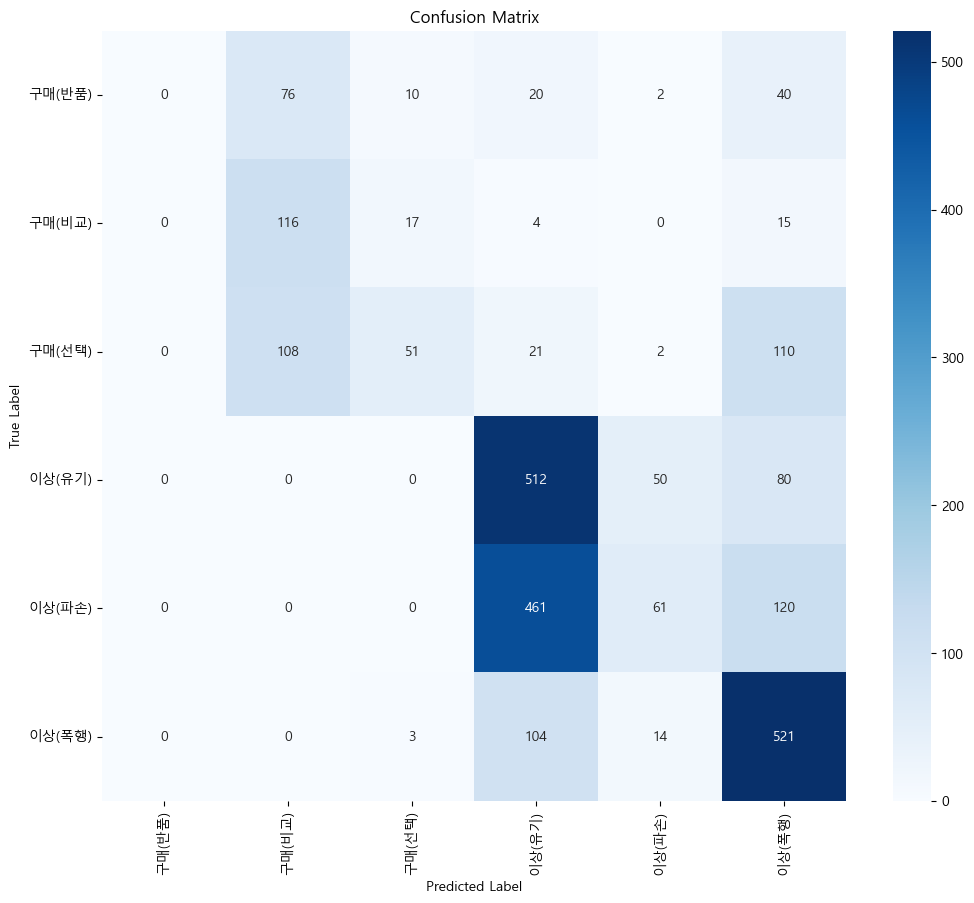

F1 Score: 0.42491622348499947

Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       148
         1.0       0.39      0.76      0.51       152
         2.0       0.63      0.17      0.27       292
         3.0       0.46      0.80      0.58       642
         4.0       0.47      0.10      0.16       642
         5.0       0.59      0.81      0.68       642

    accuracy                           0.50      2518
   macro avg       0.42      0.44      0.37      2518
weighted avg       0.48      0.50      0.42      2518



c:\Users\de31\anaconda3\envs\lp\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\de31\anaconda3\envs\lp\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\de31\anaconda3\envs\lp\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc("font", family="Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

def plot_confusion_matrix_with_labels(y_true, y_pred, labels):
    """
    Plot confusion matrix with custom labels.
    """
    matrix = confusion_matrix(y_true, y_pred, labels=np.arange(len(labels)))
    plt.figure(figsize=(12, 10))
    ax=sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels,
                yticklabels=labels)
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# 실제 레이블과 예측 레이블 (y_val와 test_pred_idx)을 사용하여 Confusion Matrix를 시각화합니다.
plot_confusion_matrix_with_labels(y_val, test_pred_idx, cate)

# F1 Score를 계산합니다.
f1 = f1_score(y_val, test_pred_idx, average='weighted')

# 결과를 출력합니다.
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_report(y_val, test_pred_idx))
